In [1]:
%load_ext autoreload
%autoreload 2

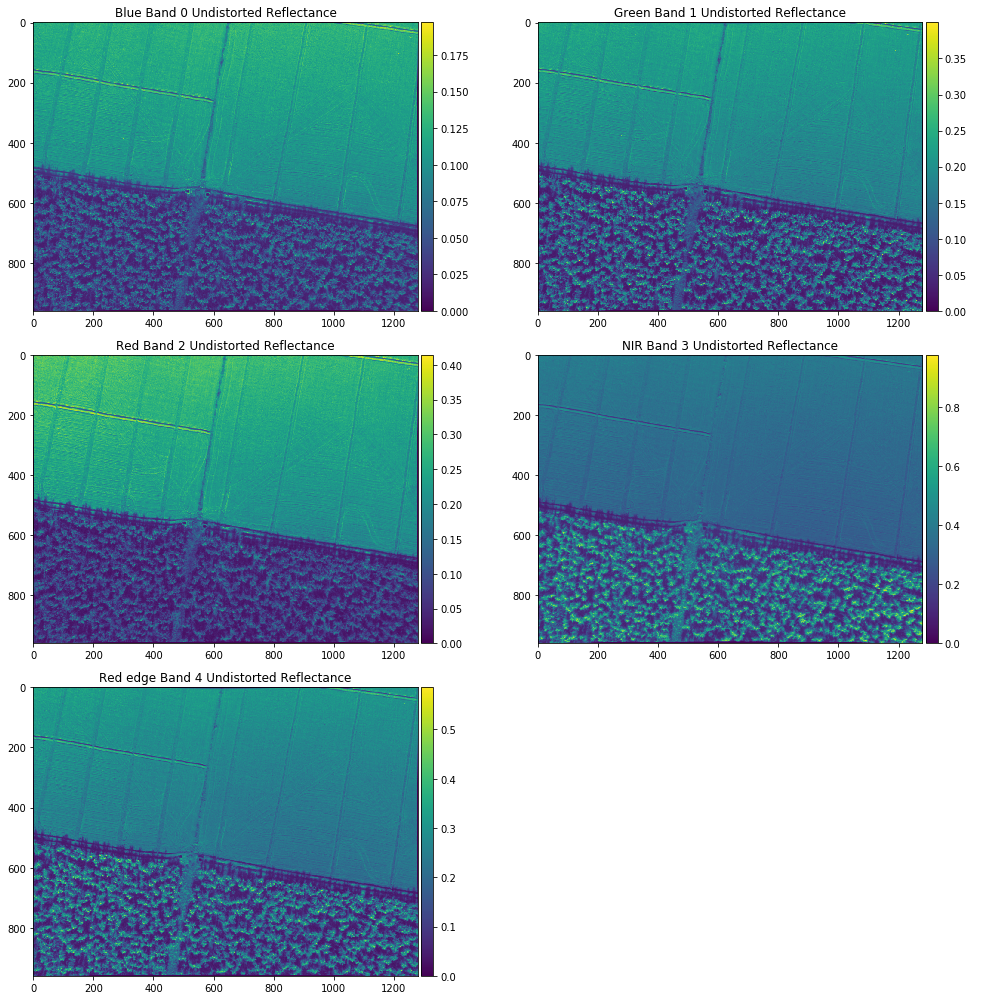

In [2]:
import os, glob
import micasense.capture as capture
%matplotlib inline

imagePath = os.path.join('.','DroneData_2/')
imageNames = glob.glob(os.path.join(imagePath,'IMG_0084_*.tif'))


capture = capture.Capture.from_filelist(imageNames)

if capture.dls_present():
    img_type='reflectance'
    capture.plot_undistorted_reflectance(capture.dls_irradiance())
else:
    img_type = "radiance"
    capture.plot_undistorted_radiance()    

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## Alignment settings
match_index = 1 # Index of the band 
max_alignment_iterations = 10
warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
# Can potentially increase max_iterations for better results, but longer runtimes
warp_matrices, alignment_pairs = imageutils.align_capture(capture,
                                                          ref_index = match_index,
                                                          max_iterations = max_alignment_iterations,
                                                          warp_mode = warp_mode,
                                                          pyramid_levels = pyramid_levels)

print("Finished Aligning, warp matrices={}".format(warp_matrices))

Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/thresh.cpp:1612: error: (-210:Unsupported format or combination of formats)  in function 'threshold'


In [ ]:
??cv2.findTransformECC

## Crop Aligned Images
After finding image alignments we may need to remove pixels around the edges which aren't present in every image in the capture.  To do this we use the affine transforms found above and the image distortions from the image metadata.  OpenCV provides a couple of handy helpers for this task in the  `cv2.undistortPoints()` and `cv2.transform()` methods.  These methods takes a set of pixel coordinates and apply our undistortion matrix and our affine transform, respectively.  So, just as we did when registering the images, we first apply the undistortion process the coordinates of the image borders, then we apply the affine transformation to that result. The resulting pixel coordinates tell us where the image borders end up after this pair of transformations, and we can then crop the resultant image to these coordinates.

In [ ]:
cropped_dimensions, edges = imageutils.find_crop_bounds(capture, warp_matrices, warp_mode=warp_mode)
im_aligned = imageutils.aligned_capture(capture, warp_matrices, warp_mode, cropped_dimensions, match_index, img_type=img_type)

## Visualize Aligned Images

Once the transformation has been found, it can be verified by composting the aligned images to check alignment. The image 'stack' containing all bands can also be exported to a multi-band TIFF file for viewing in extrernal software such as QGIS.  Usef ul componsites are a naturally colored RGB as well as color infrared, or CIR. 

In [ ]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [2,1,0]
cir_band_indices = [3,2,1]

# Create a normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

# for rgb true color, we use the same min and max scaling across the 3 bands to 
# maintain the "white balance" of the calibrated image
for i in rgb_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)

rgb = im_display[:,:,rgb_band_indices]

# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

## Image Enhancement

There are many techniques for image enhancement, but one which is commonly used to improve the visual sharpness of imagery is the unsharp mask.  Here we apply an unsharp mask to the RGB image to improve the visualization, and then apply a gamma curve to make the darkest areas brighter.

In [ ]:
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 1.4
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()

## Image Export

Composite images can be exported to JPEG or PNG format using the `imageio` package.  These images may be useful for visualization or thumbnailing, and creating RGB thumbnails of a set of images can provide a convenient way to browse the imagery in a more visually appealing way that browsing the raw imagery.   

In [ ]:
import imageio
imtype = 'png' # or 'jpg'
imageio.imwrite('rgb.'+imtype, (255*gamma_corr_rgb).astype('uint8'))
imageio.imwrite('cir.'+imtype, (255*cir).astype('uint8'))

## Stack Export

We can export the image easily stacks using the `gdal` library (http://www.glal.org). Once exported, these image stacks can be opened in software such as QGIS and raster operations such as NDVI or NDRE computation can be done in that software.  At this time the stacks don't include any geographic information.

In [ ]:
from osgeo import gdal, gdal_array
rows, cols, bands = im_display.shape
driver = gdal.GetDriverByName('GTiff')
filename = "bgrne" #blue,green,red,nir,redEdge

if im_aligned.shape[2] == 6:
    filename = filename + "t" #thermal
outRaster = driver.Create(filename+".tiff", cols, rows, im_aligned.shape[2], gdal.GDT_UInt16)

normalize = (img_type == 'radiance') # normalize radiance images to fit with in UInt16

# Output a 'stack' in the same band order as RedEdge/Alutm
# Blue,Green,Red,NIR,RedEdge[,Thermal]
# reflectance stacks are output with 32768=100% reflectance to provide some overhead for specular reflections
# radiance stacks are output with 65535=100% radiance to provide some overhead for specular reflections

# NOTE: NIR and RedEdge are not in wavelength order!

multispec_min = np.min(im_aligned[:,:,1:5])
multispec_max = np.max(im_aligned[:,:,1:5])

for i in range(0,5):
    outband = outRaster.GetRasterBand(i+1)
    if normalize:
        outdata = imageutils.normalize(im_aligned[:,:,i],multispec_min,multispec_max)
    else:
        outdata = im_aligned[:,:,i]
        outdata[outdata<0] = 0
        outdata[outdata>2] = 2
    
    outdata = outdata*32767
    outdata[outdata<0] = 0
    outdata[outdata>65535] = 65535
    outband.WriteArray(outdata)
    outband.FlushCache()

if im_aligned.shape[2] == 6:
    outband = outRaster.GetRasterBand(6)
    outdata = im_aligned[:,:,5] * 100 # scale to centi-C to fit into uint16
    outdata[outdata<0] = 0
    outdata[outdata>65535] = 65535
    outband.WriteArray(outdata)
    outband.FlushCache()
outRaster = None

### Notes on Alignment and Stack Usage

"Stacks" as described above are useful in a number of processing cases.  For example, at the time of this writing, many photogrammetry suites could import and process stack files without significantly impacting the radiometric processing which has already been accomplished.  

Running photogrammetry on stack files instead of raw image files has both advantages and drawbacks. The primary advantage has been found to be an increase in processing speed and a reduction in program memory usage. As the photogrammetric workflow generally operates on luminance images and may not use color information, stacked images may require similar resources and be processed at a similar speed as single-band images.  This is because one band of the stack can be used to generate the matching feature space while the others are ignored for matching purposes. This reduces the feature space 5-fold over matching using all images separately.

One disadvantage is that stacking images outside of the photogrammetric workflow may result in poor image matching.  The RedEdge is known to have stable lens characteristics over the course of normal operation, but variations in temperature or impacts to the camera through handling or rough landings may change the image alignment parameters.  For this reason, we recommend finding a matching transformation for each flight (each take-off and landing).  Alignment transformations from multiple images within a flight can be compared to find the best transformation to apply to the set of the flight.  While not described or supported in this generic implementation, some matching algorithms can use a "seed" value as a starting point to speed up matching.  For most cases, this seed could be the transformation found in a previous flight, or another source of a known good transformation.    

## NDVI Computation

For raw index computation on single images, the numpy package provides a simple way to do math and simple visualizatoin on images.  Below, we compute and visualize an image histogram and then use that to pick a colormap range for visualizing the NDVI of an image. 

### Plant Classification

After computing the NDVI and prior to displaying it, we use a very rudimentary method for focusing on the plants and removing the soil and shadow information from our images and histograms. Below we remove non-plant pixels by setting to zero any pixels in the image where the NIR reflectance is less than 20%.  This helps to ensure that the NDVI and NDRE histograms aren't skewed substantially by soil noise.

In [ ]:
from micasense import plotutils
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

# Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
ndvi = (im_aligned[:,:,3] - im_aligned[:,:,2]) / (im_aligned[:,:,3] + im_aligned[:,:,2])

# remove shadowed areas (mask pixels with NIR reflectance < 20%))
if img_type == 'reflectance':
    ndvi = np.ma.masked_where(im_aligned[:,:,3] < 0.20, ndvi) 
elif img_type == 'radiance':
    lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
    ndvi = np.ma.masked_where(im_aligned[:,:,3] < lower_pct_radiance, ndvi) 
    
# Compute and display a histogram
ndvi_hist_min = np.min(ndvi)
ndvi_hist_max = np.max(ndvi)
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(ndvi.ravel(), bins=512, range=(ndvi_hist_min, ndvi_hist_max))
plt.title("NDVI Histogram")
plt.show()

min_display_ndvi = 0.45 # further mask soil by removing low-ndvi values
#min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
max_display_ndvi = np.percentile(ndvi.flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values
masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)

#reduce the figure size to account for colorbar
figsize=np.asarray(figsize) - np.array([3,2])

#plot NDVI over an RGB basemap, with a colorbar showing the NDVI scale
fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndvi, 
                                    figsize = figsize, 
                                    title = 'NDVI filtered to only plants over RGB base layer',
                                    vmin = min_display_ndvi,
                                    vmax = max_display_ndvi)
fig.savefig('ndvi_over_rgb.png')

## NDRE Computation

In the same manner, we can compute, filter, and display another index useful for the RedEdge camera, the Normalized Difference Red Edge (NDRE) index.  We also filter out shadows and soil to ensure our display focuses only on the plant health.

In [ ]:
# Compute Normalized Difference Red Edge Index from the NIR(3) and RedEdge(4) bands
ndre = (im_aligned[:,:,3] - im_aligned[:,:,4]) / (im_aligned[:,:,3] + im_aligned[:,:,4])

# Mask areas with shadows and low NDVI to remove soil
masked_ndre = np.ma.masked_where(ndvi < min_display_ndvi, ndre)

# Compute a histogram
ndre_hist_min = np.min(masked_ndre)
ndre_hist_max = np.max(masked_ndre)
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(masked_ndre.ravel(), bins=512, range=(ndre_hist_min, ndre_hist_max))
plt.title("NDRE Histogram (filtered to only plants)")
plt.show()

min_display_ndre = np.percentile(masked_ndre, 5)
max_display_ndre = np.percentile(masked_ndre, 99.5)

fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndre, 
                                    figsize=figsize, 
                                    title='NDRE filtered to only plants over RGB base layer',
                                    vmin=min_display_ndre,vmax=max_display_ndre)
fig.savefig('ndre_over_rgb.png')

## Thermal Imagery

If our image is from an Altum and includes a thermal band, we can display the re-sampled and aligned thermal data over the RGB data to maintain the context of the thermal information.

In the image below, it's very clear based on the average temperature where the soil is wet and dry, and even in the middle of the road we can find some wetter areas of soil.

In [ ]:
if im_aligned.shape[2] >= 5:

    # by default we don't mask the thermal, since it's native resolution is much lower than the MS
    masked_thermal = im_aligned[:,:,5]
    # Alternatively we can mask the thermal only to plants here, which is useful for large contiguous areas
    # masked_thermal = np.ma.masked_where(ndvi < 0.45, im_aligned[:,:,5])


    # Compute a histogram
    fig, axis = plt.subplots(1, 1, figsize=(10,4))
    axis.hist(masked_thermal.ravel(), bins=512, range=(np.min(masked_thermal), np.max(masked_thermal)))
    plt.title("Thermal Histogram")
    plt.show()

    min_display_therm = np.percentile(masked_thermal, 1)
    max_display_therm = np.percentile(masked_thermal, 99)

    fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb,
                                        masked_thermal, 
                                        figsize=figsize, 
                                        title='Temperature over True Color',
                                        vmin=min_display_therm,vmax=max_display_therm,
                                        overlay_alpha=0.25,
                                        overlay_colormap='jet',
                                        overlay_steps=16,
                                        display_contours=True,
                                        contour_steps=16,
                                        contour_alpha=.4,
                                        contour_fmt="%.0fC")
    fig.savefig('thermal_over_rgb.png')

## Red vs NIR Reflectance

Finally, we show a classic agricultural remote sensing output in the tassled cap plot.  This plot can be useful for visualizing row crops and plots the Red Reflectance channel on the X-axis against the NIR reflectance channel on the Y-axis. This plot also clearly shows the line of the soil in that space.  The tassled cap view isn't very useful for this arid data set; however, we can see the "badge of trees" of high NIR reflectance and relatively low red reflectance. This provides an example of one of the uses of aligned images for single capture analysis.

In [ ]:
bands = ['blue','green','red','nir','rededge']
x_band = 2
y_band = 3
x_max = np.max(im_aligned[:,:,x_band])
y_max = np.max(im_aligned[:,:,y_band])

fig = plt.figure(figsize=(12,12))
plt.hexbin(im_aligned[:,:,x_band],im_aligned[:,:,y_band],gridsize=640,bins='log',extent=(0,x_max,0,y_max))
ax = fig.gca()
ax.set_xlim([0,x_max])
ax.set_ylim([0,y_max])
plt.xlabel("{} Reflectance".format(bands[x_band]))
plt.ylabel("{} Reflectance".format(bands[y_band]))
plt.show()

## Print warp_matrices for usage elsewhere, such as Batch Processing
Last, we output the warp_matrices that we got for this image stack for usage elsewhere. Currently these can be used in the `Batch Processing.ipynb` notebook to save reflectance-compensated stacks of images to a directory.

In [ ]:
print(warp_matrices)

---
Copyright (c) 2017-2018 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)